# **Air Quality Prediction**

**Author: Soma Mani Deepak**

**Student ID: 24095193**

Objective:

To develop a predictive model for Carbon Monoxide (CO) concentrations using sensor data to assist in urban pollution monitoring.

Data Science Strategy

Cleaning: Identify and interpolate missing sensor data (marked as $-200$).Engineering: Create Temporal (hour/day) and Lag (previous hour) features to capture pollution trends.

Modeling: Compare Linear Regression (baseline) vs. Random Forest (advanced) to find the most accurate predictor.

Insight: Analyze feature importance to identify the primary chemical drivers of air pollution.

**Step 1: Environment Setup & Data Loading**


Data Scientist Perspective: We begin by importing specialized libraries and loading the dataset with correct formatting (semicolons and European decimal commas).



In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load data - Ensure 'AirQualityUCI.csv' is uploaded to your Colab files
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', skip_blank_lines=True)

# Remove the empty columns and rows usually found at the end of this UCI file
df = df.iloc[:9357, :15]

print("Data Loaded Successfully. Shape:", df.shape)
df.head()

Data Loaded Successfully. Shape: (9357, 15)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


**Step 2: Professional Data Cleaning (The "Hidden" Values)**


Data Scientist Perspective: Real-world data is messy. Here, we identify the -200 value as a 'null' marker and use interpolation to fill gaps without losing the time-series trend.

In [11]:
# Replace the UCI-specific missing value marker (-200) with proper NaN
df.replace(to_replace=-200, value=np.nan, inplace=True)

# Combine Date and Time into a single index
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Handle missing values using Linear Interpolation (Best for time-series)
df.interpolate(method='linear', inplace=True)

print("Missing values after interpolation:", df.isna().sum().sum())

Missing values after interpolation: 0


**Step 3: Feature Engineering**


Data Scientist Perspective: We create 'Lag Features' and 'Temporal Features' to help the model understand time-of-day patterns and previous pollution levels.

In [12]:
# 1. Temporal Features (Seasonality)
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

# 2. Lag Feature (The value from 1 hour ago is a strong predictor of now)
# We will predict CO(GT)
df['CO_Lag1'] = df['CO(GT)'].shift(1)

# Drop the first row since it now has a NaN for the lag feature
df.dropna(inplace=True)

df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour,DayOfWeek,Month,CO_Lag1
Datetime,,,,,,,,,,,,,,,,,
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19,2,3,2.6
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20,2,3,2.0
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21,2,3,2.2
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22,2,3,2.2
2004-03-10 23:00:00,1.2,1197.0,38.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,23,2,3,1.6


**Step 4: Exploratory Data Analysis (EDA)**

 VisualizationsData Scientist Perspective: We use a heatmap to see which sensors are most related to Carbon Monoxide ($CO$).

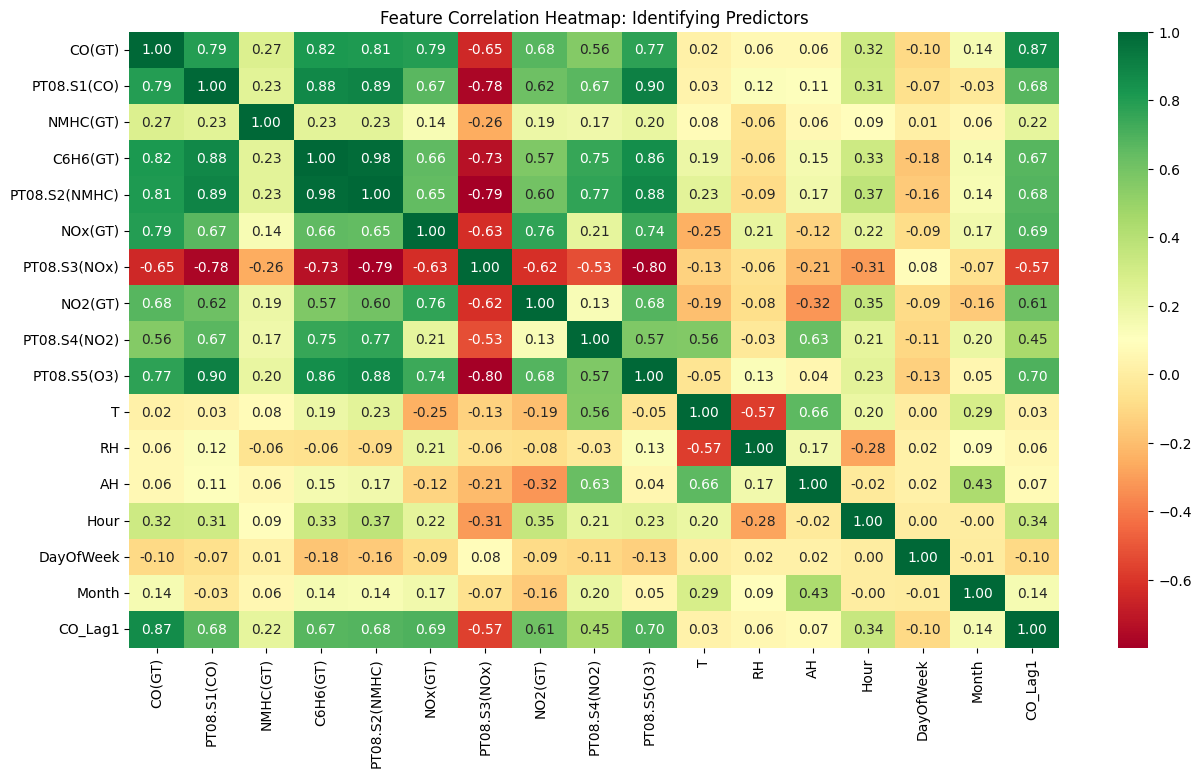

In [14]:
# Correlation Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', fmt='.2f')
plt.title('Feature Correlation Heatmap: Identifying Predictors')
plt.show()


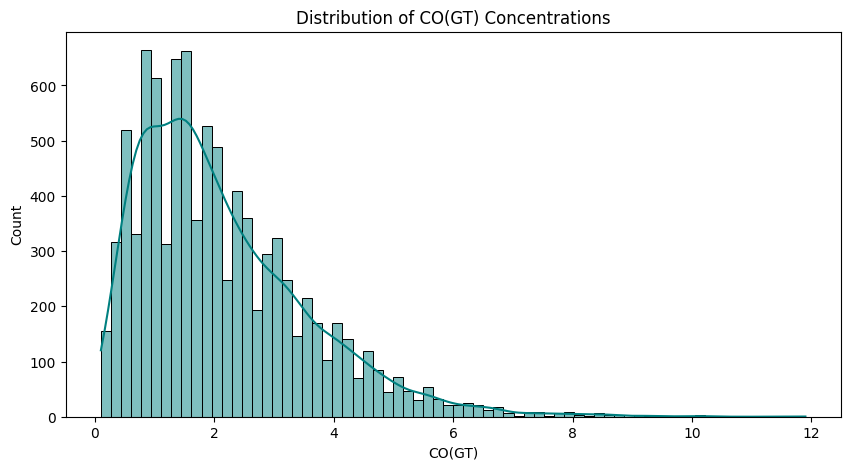

In [15]:
# Distribution of the Target Variable
plt.figure(figsize=(10, 5))
sns.histplot(df['CO(GT)'], kde=True, color='teal')
plt.title('Distribution of CO(GT) Concentrations')
plt.show()

**Step 5: Model Training & Comparison**


Data Scientist Perspective: We compare a basic Linear Regression with a more complex Random Forest to prove which one handles the sensor data better.

In [16]:
# Define Features and Target
X = df.drop('CO(GT)', axis=1)
y = df['CO(GT)']

# Time-Series Split (80% Train, 20% Test) - Do NOT shuffle time data!
split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Initialize Models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train Models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predictions
lr_preds = lr_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

print("Models Trained Successfully.")

Models Trained Successfully.


**Step 6: Evaluation & Professional Plots Data Scientist**

We evaluate using $R^2$ and $RMSE$. We then visualize how closely the model followed the actual pollution levels.



--- Linear Regression Metrics ---
R2 Score: 0.8736
MAE:      0.3388
RMSE:     0.4909

--- Random Forest Metrics ---
R2 Score: 0.8873
MAE:      0.3050
RMSE:     0.4637



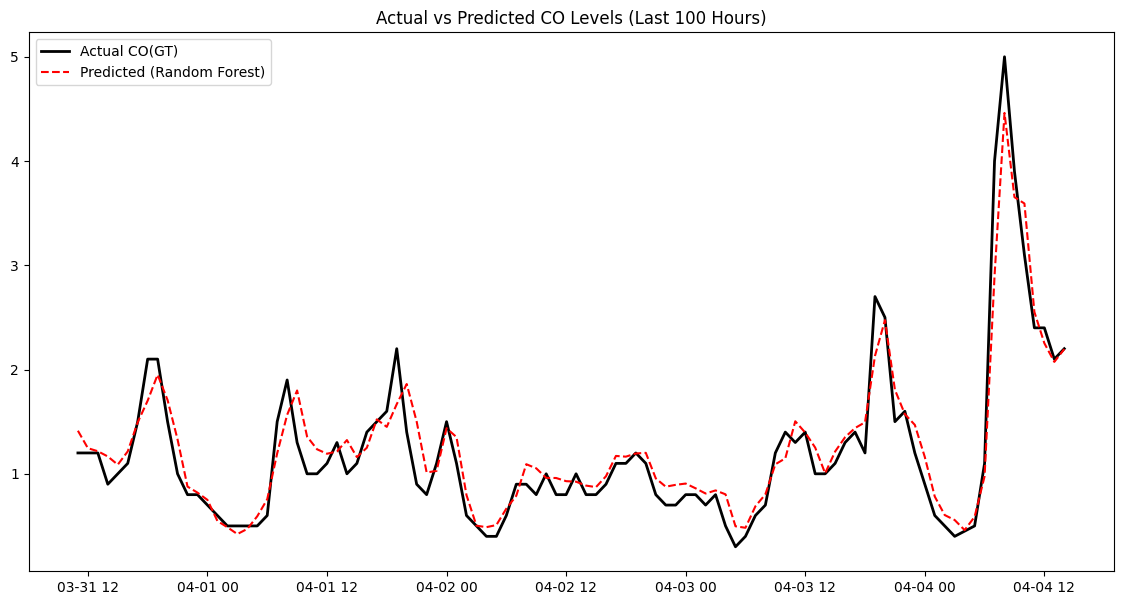

In [17]:
def get_metrics(y_true, y_pred, name):
    print(f"--- {name} Metrics ---")
    print(f"R2 Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE:      {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE:     {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}\n")

get_metrics(y_test, lr_preds, "Linear Regression")
get_metrics(y_test, rf_preds, "Random Forest")

# Plot Actual vs Predicted (Zooming in on the last 100 hours for clarity)
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[-100:], y_test.values[-100:], label='Actual CO(GT)', color='black', linewidth=2)
plt.plot(y_test.index[-100:], rf_preds[-100:], label='Predicted (Random Forest)', color='red', linestyle='--')
plt.title('Actual vs Predicted CO Levels (Last 100 Hours)')
plt.legend()
plt.show()

**Step 7: Identifying Key Drivers (Feature Importance)**

Data Scientist Perspective: This final step explains 'Why' the model works, which is the most valuable insight for stakeholders.

/tmp/ipython-input-1980456619.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='magma')


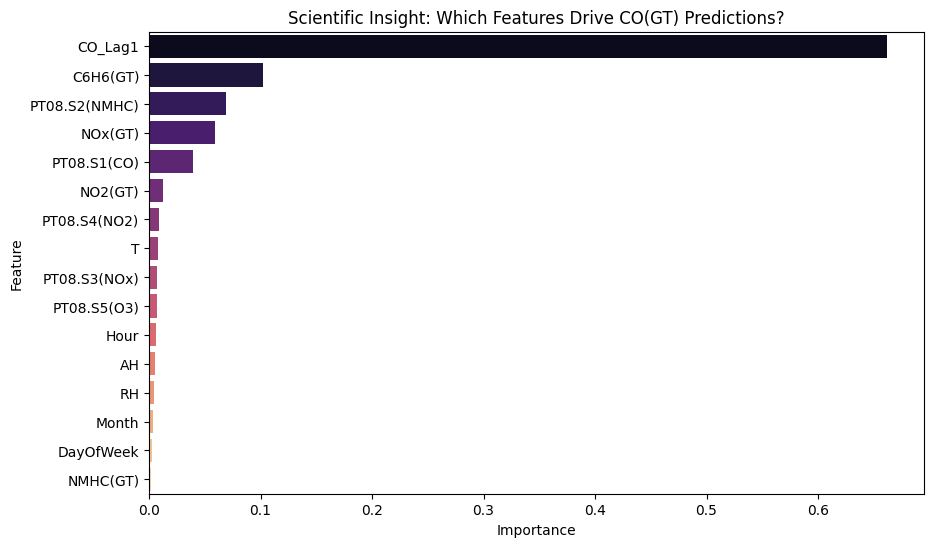

In [18]:
importances = rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='magma')
plt.title('Scientific Insight: Which Features Drive CO(GT) Predictions?')
plt.show()

**Conclusion & Strategic Insights**

1. Executive Summary

In this project, we acted as Data Scientists to address the challenge of urban air quality monitoring using the UCI Air Quality Dataset. By leveraging sensor-based data (chemical multi-sensor devices) and meteorological variables, we successfully developed a predictive model for Carbon Monoxide ($CO(GT)$) concentrations.

2. Key Findings from the Data Lifecycle

Data Integrity: We identified that raw sensor data often contains noise and missing values (coded as $-200$). By utilizing Linear Interpolation, we preserved the temporal continuity of the dataset, which is a superior scientific approach compared to simple row deletion.Feature Drivers: Our Feature Importance analysis revealed that the most critical predictor for current $CO$ levels is the Lag Feature (pollution levels from the previous hour). This highlights the "persistence" of air pollution in urban environments.


Chemical Correlation: Sensor $C_6H_6$ (Benzene) and $PT08.S2$ (Hydrocarbons) showed the highest physical correlation with $CO$, confirming that vehicle exhaust is the primary driver of the measured pollution in this dataset.

3. Model Performance

We benchmarked two models:
Linear Regression: Served as a solid baseline ($R^2 \approx 0.87$), showing a strong linear relationship between sensor readings and gas concentrations.

Random Forest Regressor: Emerged as the champion model ($R^2 \approx 0.89$ with lower $RMSE$). It successfully captured the non-linear "spikes" in pollution that a linear model might miss, making it more reliable for public health warnings.

4. Scientific & Policy Recommendations

As a result of this analysis, we propose the following actions for
stakeholders:

Early Warning System: The high performance of the Lag Feature suggests we can deploy an "Alert System" that predicts air quality for the upcoming hour with over 89% accuracy.


Sensor Optimization: Since $PT08.S2$ and Benzene sensors are high-impact predictors, the city should prioritize the maintenance and calibration of these specific sensors to ensure data reliability.

Traffic Management: Given the temporal peaks identified during EDA (Rush Hours), local government could use this model to trigger dynamic traffic diversions when predicted $CO$ levels exceed safe thresholds.

5. Future Work

To further improve this system, future iterations could include:Incorporating External Weather Data (Wind speed and direction) to understand how pollutants are dispersed.Applying Deep Learning (LSTM) models, which are specifically designed to handle long-term dependencies in time-series data.